This is the first of a few posts covering some of the new features added to the RDKit in the 2023.09.1 release.

The full release notes are [available here](https://github.com/rdkit/rdkit/releases/tag/Release_2023_09_1).

Note: starting in this release cycle we are going to try changing the RDKit release model to include new features in minor releases. So the 2023.09.2 release may potentially include new features. There's some description of the thinking behind this change in [this blog post](https://greglandrum.github.io/rdkit-blog/posts/2023-08-25-about-rdkit-versioning.html).

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import rdkit
print(rdkit.__version__)

2023.09.1


# Generalized substructure search



I wrote a [blog post](https://greglandrum.github.io/rdkit-blog/posts/2021-08-03-generalized-substructure-search.html) on this topic a while ago. The functionality in this release builds on and refines the ideas in that post.

Here are some molecules we'll do queries against

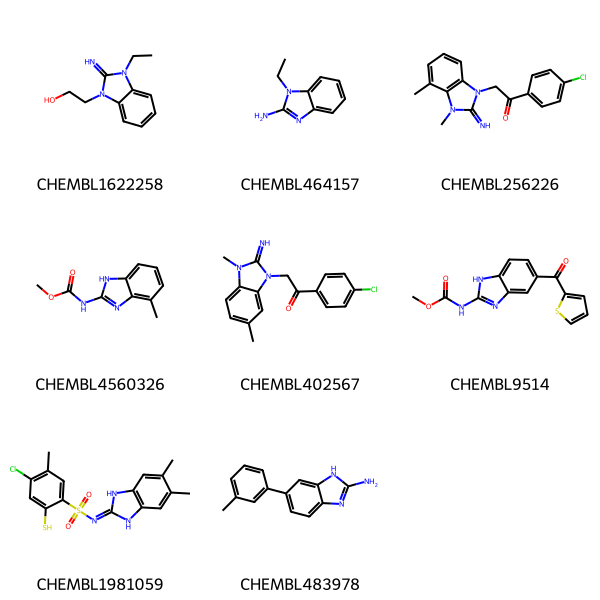

In [27]:
data = [('CHEMBL1622258','CCn1c(=N)n(CCO)c2ccccc21'),
        ('CHEMBL464157','CCn1c(N)nc2ccccc21'),
        ('CHEMBL256226','Cc1cccc2c1n(C)c(=N)n2CC(=O)c1ccc(Cl)cc1'),
        ('CHEMBL4560326','COC(=O)Nc1nc2c(C)cccc2[nH]1'),
        ('CHEMBL402567','Cc1ccc2c(c1)n(CC(=O)c1ccc(Cl)cc1)c(=N)n2C'),
        ('CHEMBL9514','COC(=O)Nc1nc2cc(C(=O)c3cccs3)ccc2[nH]1'),
        ('CHEMBL1981059','Cc1cc2[nH]c(=NS(=O)(=O)c3cc(C)c(Cl)cc3S)[nH]c2cc1C'),
        ('CHEMBL483978','Cc1cccc(-c2ccc3nc(N)[nH]c3c2)c1'),
       ]

nms,smis = zip(*data)
mols = [Chem.MolFromSmiles(x) for x in smis]
Draw.MolsToGridImage(mols,legends=nms)

And a query which has both a variable attachment point and some possible tautomers.

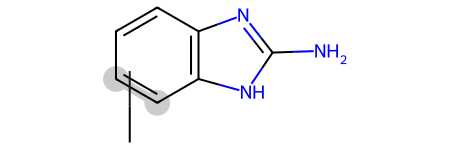

In [28]:
qry = Chem.MolFromMolBlock('''
  Mrv2211 10142305482D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 12 12 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -4.7499 1.9567 0 0
M  V30 2 C -6.0836 1.1867 0 0
M  V30 3 C -6.0836 -0.3534 0 0
M  V30 4 C -4.7499 -1.1234 0 0
M  V30 5 C -3.4163 -0.3534 0 0
M  V30 6 C -3.4163 1.1867 0 0
M  V30 7 N -1.9692 1.7134 0 0
M  V30 8 N -1.8822 -0.7768 0 0
M  V30 9 C -1.0211 0.4999 0 0
M  V30 10 * -5.639 -0.0967 0 0
M  V30 11 C -5.639 -2.4067 0 0
M  V30 12 N 0.518 0.5537 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 8 9
M  V30 8 1 7 6
M  V30 9 1 5 8
M  V30 10 2 7 9
M  V30 11 1 10 11 ENDPTS=(2 4 3) ATTACH=ANY
M  V30 12 1 9 12
M  V30 END BOND
M  V30 END CTAB
M  END
''')
qry

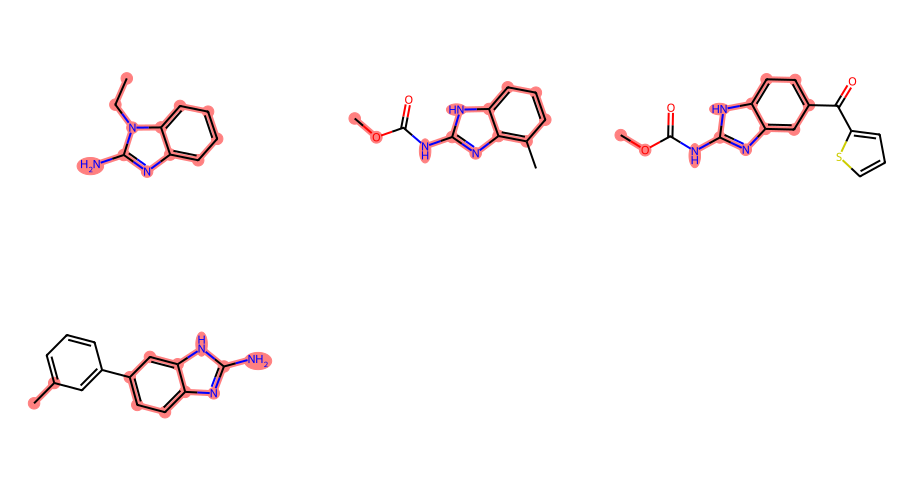

In [29]:
def filter_and_draw_with_highlights(mols,query_func):
    keep = []
    matches = []
    for mol in mols:
        match = query_func(mol)
        if match:
            keep.append(mol)
            matches.append(match)
    return Draw.MolsToGridImage(keep,highlightAtomLists=matches,subImgSize=(300,250))
filter_and_draw_with_highlights(mols,lambda x,q=qry: x.GetSubstructMatch(qry))

Some of those matches are surprising/ugly since the RDKit is just treating the variable attachment point as a carbon connected to a dummy atom which is not bound to the main scaffold, basically this:

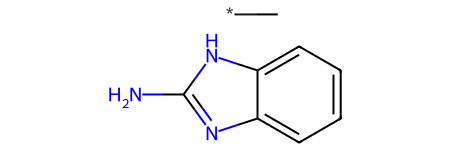

In [30]:
Chem.MolFromSmiles(Chem.MolToSmiles(qry))

In order to actually use the query feature, we need to create an extended query molecule and then use the generalized substructure search functionality:

In [31]:
from rdkit.Chem import rdGeneralizedSubstruct
xqm = rdGeneralizedSubstruct.CreateExtendedQueryMol(qry)

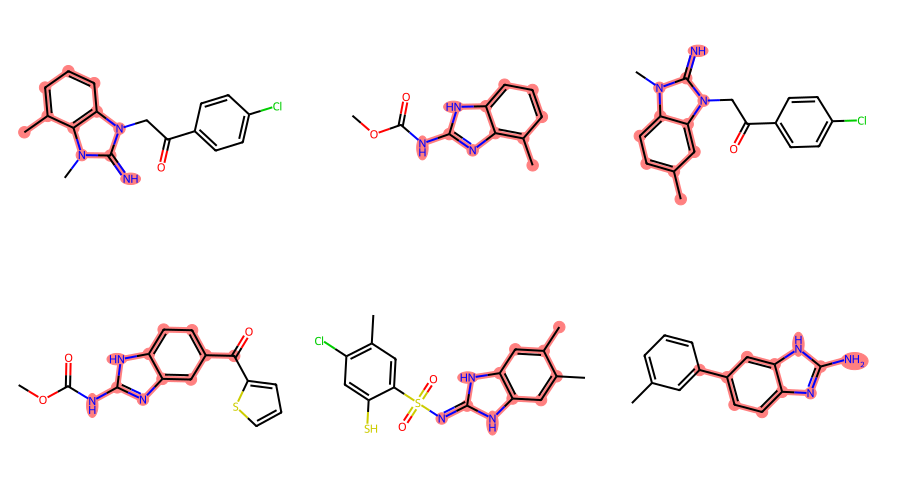

In [32]:
filter_and_draw_with_highlights(mols,lambda x,q=xqm: rdGeneralizedSubstruct.MolGetSubstructMatch(x,q))

`CreateExtendedQueryMol()` can also call `AdjustQueryProperties()`. Here's a demo of using that to only return matches where there are no additional ring substitutions:

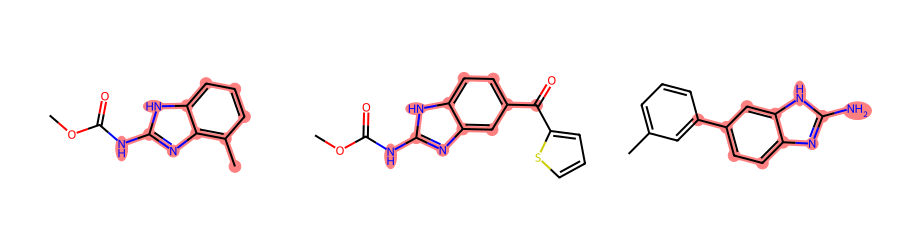

In [33]:
ps = Chem.AdjustQueryParameters.NoAdjustments()
ps.adjustDegreeFlags = Chem.AdjustQueryWhichFlags.ADJUST_IGNORECHAINS
ps.adjustDegree = True
xqm = rdGeneralizedSubstruct.CreateExtendedQueryMol(qry,adjustQueryProperties=True,adjustQueryParameters=ps)

filter_and_draw_with_highlights(mols,lambda x,q=xqm: rdGeneralizedSubstruct.MolGetSubstructMatch(x,q))

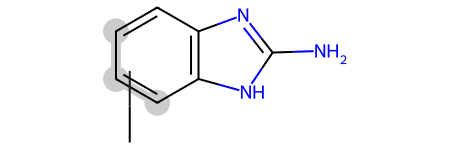

In [38]:
qry2 = Chem.MolFromMolBlock('''
  Mrv2211 10162305072D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 12 12 1 0 0
M  V30 BEGIN ATOM
M  V30 1 C -4.7499 1.9567 0 0
M  V30 2 C -6.0836 1.1867 0 0
M  V30 3 C -6.0836 -0.3534 0 0
M  V30 4 C -4.7499 -1.1234 0 0
M  V30 5 C -3.4163 -0.3534 0 0
M  V30 6 C -3.4163 1.1867 0 0
M  V30 7 N -1.9692 1.7134 0 0
M  V30 8 N -1.8822 -0.7768 0 0
M  V30 9 C -1.0211 0.4999 0 0
M  V30 10 * -5.639 -0.0967 0 0
M  V30 11 C -5.639 -2.4067 0 0
M  V30 12 N 0.518 0.5537 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 8 9
M  V30 8 1 7 6
M  V30 9 1 5 8
M  V30 10 2 7 9
M  V30 11 1 10 11 ENDPTS=(3 4 3 2) ATTACH=ANY
M  V30 12 1 9 12
M  V30 END BOND
M  V30 BEGIN SGROUP
M  V30 1 SUP 0 -
M  V30 ATOMS=(1 10) -
M  V30 LABEL="ARY"
M  V30 END SGROUP
M  V30 END CTAB
M  END
''')
qry2

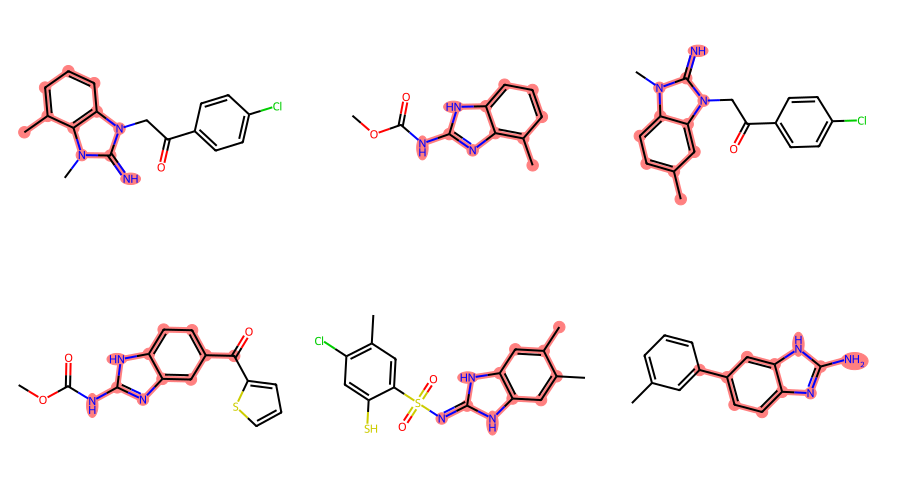

In [37]:
Chem.SetGenericQueriesFromProperties(qry2)
xqm2 = rdGeneralizedSubstruct.CreateExtendedQueryMol(qry2)

sssParams = Chem.SubstructMatchParameters()
sssParams.useGenericMatchers = True
filter_and_draw_with_highlights(mols,lambda x,q=xqm2: rdGeneralizedSubstruct.MolGetSubstructMatch(x,q,params=sssParams))

# Using generics and generalized substructure search with the PostgreSQL cartridge

The generalized substructure functionality is also available in the cartridge as is the ability to search with "Beilstein" generic queries.

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
%load_ext sql

Start with a generic query:

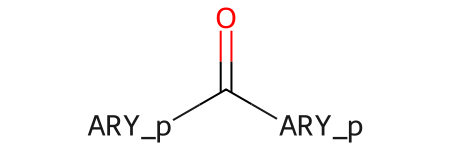

In [2]:
Chem.MolFromSmiles('O=C(-*)(-*) |$;;ARY_p;ARY_p$|')

By default query the generics are just used as dummy atoms, so the results we get from the query ignore the "ARY" groups:

10 rows affected.


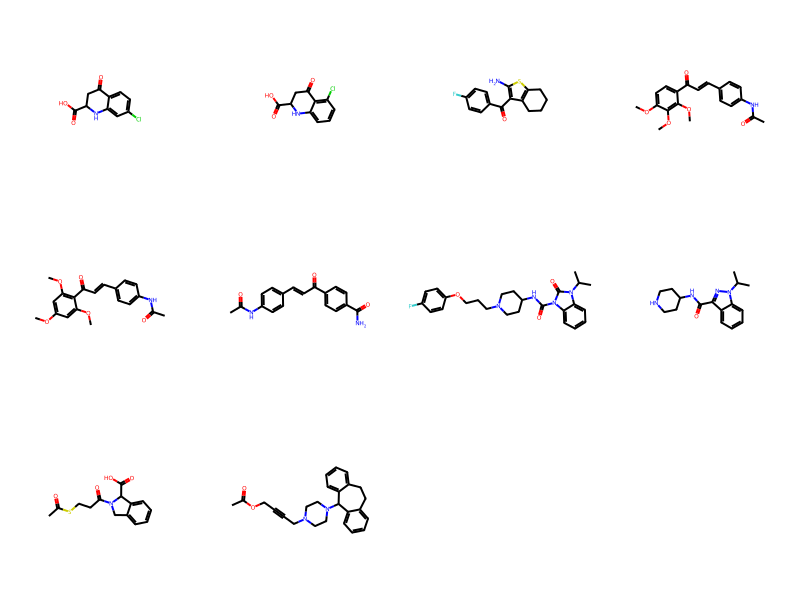

In [3]:
d = %sql postgresql://localhost/chembl_31 \
  select * from rdk.million_mols where m @>> mol_adjust_query_properties('O=C(-*)(-*) |$;;ARY_p;ARY_p$|'::mol, \
                        '{"adjustDegree": false, "makeDummiesQueries": true}')\
            order by molregno asc limit 10;
ms = [Chem.MolFromSmiles(y) for x,y in d]
Draw.MolsToGridImage(ms,molsPerRow=4)

But by passing `setGenericQueryFromProperties` to `mol_adjust_query_properties()` we tell the cartridge to use the generics groups:

In [4]:
%sql postgresql://localhost/chembl_31 \
  select  'CC(=O)C'::mol @>> mol_adjust_query_properties('O=C(-*)(-*) |$;;ARY_p;ARY_p$|'::mol, \
                        '{"setGenericQueryFromProperties": true, "adjustDegree": false}');

1 rows affected.


?column?
False


10 rows affected.


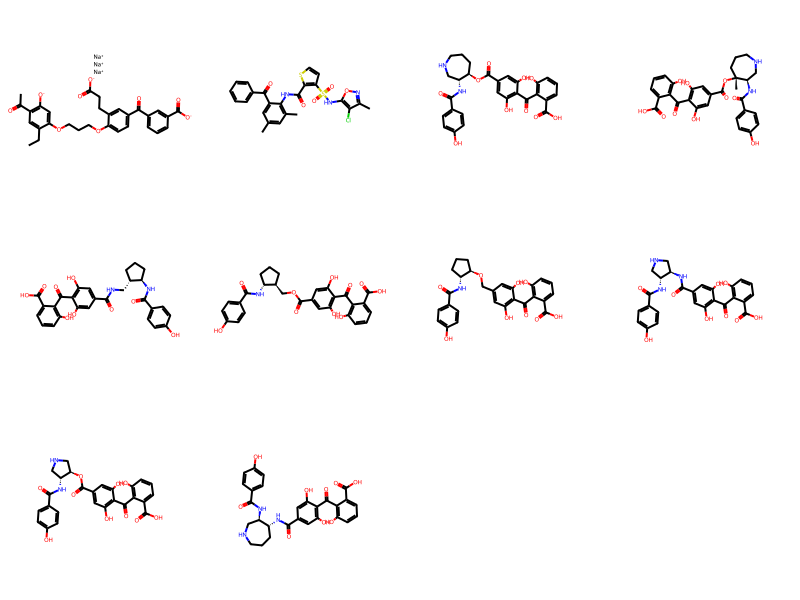

In [5]:
d = %sql postgresql://localhost/chembl_31 \
  select * from rdk.million_mols where m @>> mol_adjust_query_properties('O=C(-*)(-*) |$;;ARY_p;ARY_p$|'::mol, \
                        '{"setGenericQueryFromProperties": true, "adjustDegree": false, "makeDummiesQueries": true}')\
            order by molregno asc limit 10;
ms = [Chem.MolFromSmiles(y) for x,y in d]
Draw.MolsToGridImage(ms,molsPerRow=4)

Now let's look at using generalized substructure search by starting with a query molecule drawn as a tautomer which doesn't exist in ChEMBL:

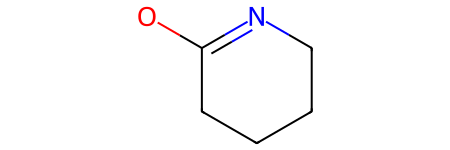

In [6]:
mb = '''
     RDKit          2D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 7 7 1 0 0
M  V30 BEGIN ATOM
M  V30 1 C 1.208608 -2.457143 0.000000 0
M  V30 2 C 2.445787 -1.742857 0.000000 0
M  V30 3 C 2.445787 -0.314286 0.000000 0
M  V30 4 N 1.208608 0.400000 0.000000 0
M  V30 5 C -0.028571 -0.314286 0.000000 0
M  V30 6 C -0.028571 -1.742857 0.000000 0
M  V30 7 O -1.265751 0.400000 0.000000 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 1 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 1 6 1
M  V30 7 1 5 7
M  V30 END BOND
M  V30 BEGIN SGROUP
M  V30 1 DAT 0 ATOMS=(1 7) FIELDDISP="    0.0000    0.0000    DR    ALL  0 0" -
M  V30 QUERYTYPE=SMARTSQ QUERYOP== FIELDDATA="[#8&X1]"
M  V30 END SGROUP
M  V30 END CTAB
M  END
$$$$
'''
m = Chem.MolFromMolBlock(mb)
m

In [7]:
Chem.MolToSmarts(m)

'[#6]1-[#6]-[#6]-[#7]=[#6](-[#6]-1)-[#8&X1]'

This doesn't return any results:

In [8]:
d = %sql postgresql://localhost/chembl_31 \
  select * from rdk.million_mols where m @> mol_from_ctab(:mb)\
            order by molregno asc limit 10;
if not len(d):
    raise ValueError('no matches!')
ms = [Chem.MolFromSmiles(y) for x,y in d]
Draw.MolsToGridImage(ms,molsPerRow=4)

0 rows affected.


ValueError: no matches!

But we can enable generalized substructure search by calling `mol_to_xqmol()` (this creates an extended query molecule, discussed above) and using that for the substructure search:

10 rows affected.


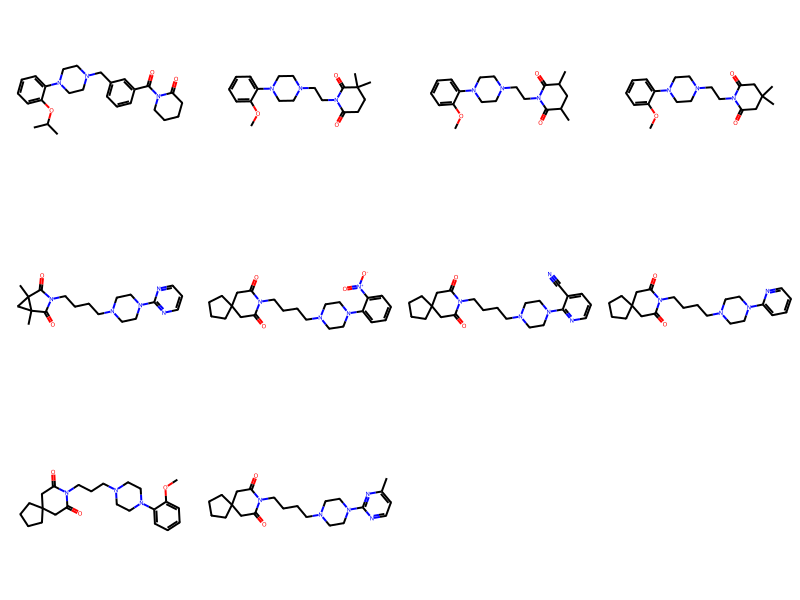

In [9]:
d = %sql postgresql://localhost/chembl_31 \
  select * from rdk.million_mols where m @> mol_to_xqmol(mol_from_ctab(:mb))\
            order by molregno asc limit 10;
ms = [Chem.MolFromSmiles(y) for x,y in d]
Draw.MolsToGridImage(ms,molsPerRow=4)

Here's a demo that this works with link nodes and tautomers:

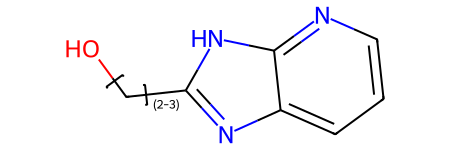

In [10]:
qry = Chem.MolFromSmiles('OCc1nc2cccnc2[nH]1 |LN:1:2.3|')
qry

6 rows affected.


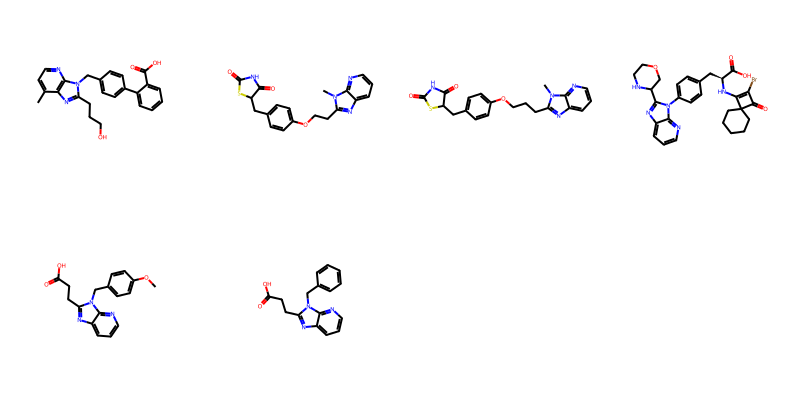

In [11]:
d = %sql postgresql://localhost/chembl_31 \
  select * from rdk.million_mols where m @> mol_to_xqmol('OCc1nc2cccnc2[nH]1 |LN:1:2.3|')\
            limit 10;
ms = [Chem.MolFromSmiles(y) for x,y in d]
Draw.MolsToGridImage(ms,molsPerRow=4)

And, as a final demo, link nodes, variable attachment points, and tautomers:

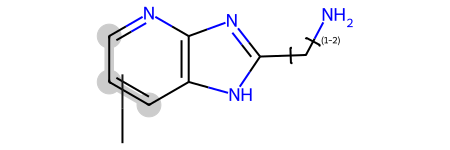

In [12]:
mb = '''qry 
  Mrv2305 09052314502D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 13 13 0 0 0
M  V30 BEGIN ATOM
M  V30 1 N -4.75 1.9567 0 0
M  V30 2 C -6.0837 1.1867 0 0
M  V30 3 C -6.0837 -0.3534 0 0
M  V30 4 C -4.75 -1.1234 0 0
M  V30 5 C -3.4163 -0.3534 0 0
M  V30 6 C -3.4163 1.1867 0 0
M  V30 7 N -1.9692 1.7134 0 0
M  V30 8 N -1.8822 -0.7768 0 0
M  V30 9 C -1.0211 0.4999 0 0
M  V30 10 C 0.5179 0.5536 0 0
M  V30 11 N 1.2409 1.9133 0 0
M  V30 12 * -5.6391 -0.0967 0 0
M  V30 13 C -5.6391 -2.4067 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 8 9
M  V30 8 1 7 6
M  V30 9 1 5 8
M  V30 10 2 7 9
M  V30 11 1 9 10
M  V30 12 1 10 11
M  V30 13 1 12 13 ENDPTS=(3 4 3 2) ATTACH=ANY
M  V30 END BOND
M  V30 LINKNODE 1 2 2 10 9 10 11
M  V30 END CTAB
M  END'''
Chem.MolFromMolBlock(mb)

8 rows affected.


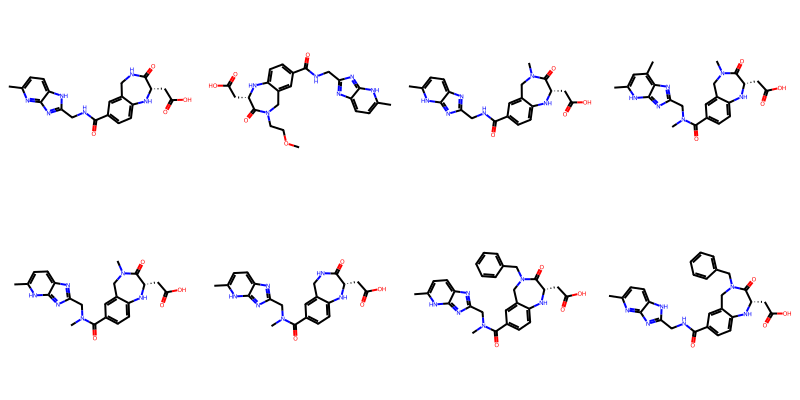

In [13]:
d = %sql postgresql://localhost/chembl_31 \
  select * from rdk.million_mols where m @> mol_to_xqmol(mol_from_ctab(:mb))\
            limit 10;
ms = [Chem.MolFromSmiles(y) for x,y in d]
Draw.MolsToGridImage(ms,molsPerRow=4)